# CS 445 Course Project

## Setup

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
datadir = "/Users/braydenturner/projects/MCS/cs445/course_project/" 

In [4]:
# %matplotlib notebook
%matplotlib widget

# Load Images

In [76]:
class Image:
    def __init__(self, path):
        self.image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB).astype('double') / 255.0

In [77]:
img1 = Image('images/whale_1.jpg')
img2 = Image('images/whale_2.jpg')

## Point Correspondence

In [78]:
def specify_corresponding_points(img, clicked = None):
    fig = plt.figure()
    if clicked:
        num = len(clicked[0])
        fig.set_label(f'Choose {num} corresponding points on image. Press q to quit')
    else:
        fig.set_label('Choose points on image. Press q to quit')
    plt.axis('off')
    plt.imshow(img)
    xs = []
    ys = []
    clicked = []

    def on_mouse_pressed(event):
        x = event.xdata
        y = event.ydata
        xs.append(x)
        ys.append(y)
        
        counter = len(xs)
        
        plt.plot(x, y, "r+")
        plt.text(x + 5, y + 5, counter, color="red")

    def onclose(event):
        clicked.append(xs)
        clicked.append(ys)
        
    def key_press(event):
        if event.key == 'q':
            print("Quitting")
            clicked.append(xs)
            clicked.append(ys)
            plt.close(fig)
            
        
        
    # Create an hard reference to the callback not to be cleared by the garbage
    # collector
    fig.canvas.mpl_connect('button_press_event', on_mouse_pressed)
    fig.canvas.mpl_connect('close_event', onclose)
    fig.canvas.mpl_connect('key_press_event', key_press)
    return clicked

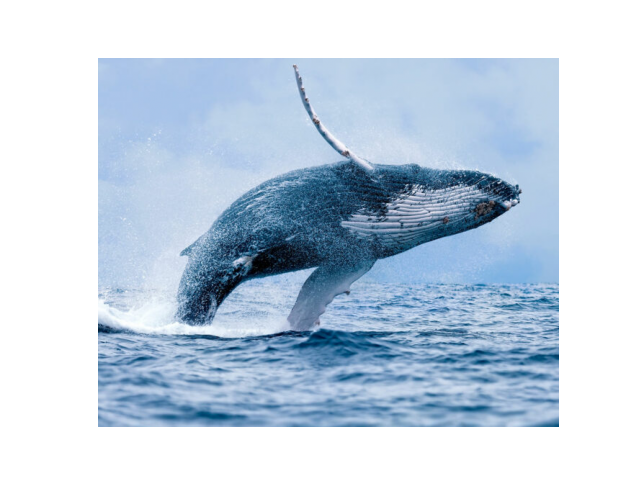

In [79]:
img1.pts = specify_corresponding_points(img1.image)

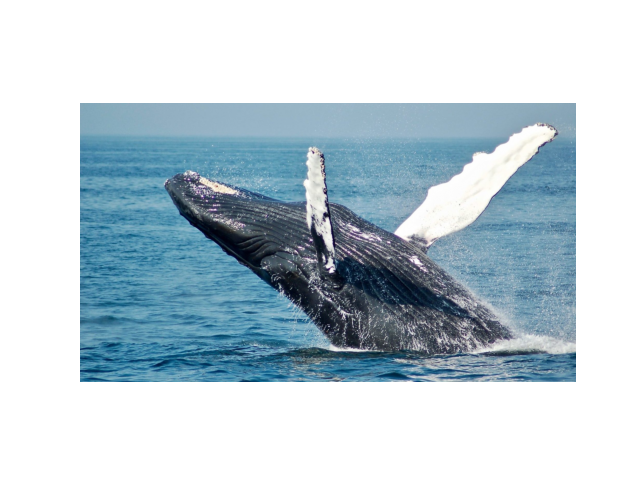

In [80]:
img2.pts = specify_corresponding_points(img2.image, img1.pts)

In [81]:
# Assert we have equal number of points
assert len(img1.pts) == len(img2.pts) and len(img1.pts[0]) == len(img2.pts[0])  and len(img1.pts[1]) == len(img2.pts[1])

## Triangulation Mesh

## Linear Interpolation

## Affine Transformation

## Tie It All Together